# Task table example

This example shows how to load a task table to the Proteus instrument in PXIe form factor

In [21]:
import os
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
#from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst 

In [22]:

%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt


## Open communication to instrument with LAN

In [23]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = 'TCPIP::192.168.1.24::5025::SOCKET'
#inst_addr = 'TCPIP::169.254.37.253::5025::SOCKET'

inst = TEVisaInst(inst_addr)

resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp)


connected to: Tabor Electronics,P9484M,000000220718,1.240.35 --slot#: 2, 


## Connect to instrument and initialize

In [24]:
# The paranoia-level is either 
# low (0), normal (1) or debug (2)
paranoia_level = 2

print ('Reset instrument ..')

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

if model_name.startswith('P948'):
    bpp = 2
    dac_mode = 16 
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 1
elif model_name.startswith('P908'):
    bpp = 1
    dac_mode = 8
    max_dac = 255
    wpt_type = np.uint8
    offset_factor = 1
else:
    bpp = 2
    dac_mode = 16 
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 2
    
half_dac = max_dac / 2.0
    

print('DAC mode {0} bits'.format(dac_mode))
# Get number of channels
resp =inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.send_scpi_query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

max_dac = 2 ** dac_mode - 1
half_dac = max_dac // 2.0

print('Done.')

Reset instrument ..
Model: P9484M 
DAC mode 16 bits
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 17,171,434,432 wave-bytes
Done.


## Prepare wave-data and markers-data for 12 segments

Prepare three types of waveforms, sine, triangle and square with varying number of cycles. 
Prepare marker for each waveform.


In [25]:
#Set number of waveform segments to build
NumofSegments = 4

waves = [ None for _ in range(NumofSegments)]
marks = [ None for _ in range(NumofSegments)]

#Set segment length
seglen = 2 ** 12 # 1MB
num_cycles = [2 ** n for n in range(NumofSegments)]

if dac_mode == 16:
    seg_wave_bytes = seglen * 2
else:
    seg_wave_bytes = seglen

seg_mark_bytes = seg_wave_bytes // 8

for ii in range(NumofSegments):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    print(ii)
    print('Prepare sine wave')
    if ii % 3 == 0:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
        y = (np.sin(x) + 1.0) * half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    print('Prepare triangle waveform')
    if ii % 3 == 1:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
        y = np.sin(x)
        y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    print('Prepare square waveform')
    if ii % 3 == 2:
        x = np.linspace(start=0, stop=seglen, num=seglen, endpoint=False)
        y = np.fmod(x, cyclelen)
        y = (y <= cyclelen / 2) * max_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    
    #Prepare marker
    if dac_mode == 16:
        cycle_bytes = cyclelen // 4
    else:
        cycle_bytes = cyclelen // 8
    
    x = np.linspace(start=0, stop=seg_mark_bytes, num=seg_mark_bytes, endpoint=False)
    y = np.fmod(x, cycle_bytes)
    y = (y <= cycle_bytes / 2) * 255
    y = np.round(y)
    y = np.clip(y, 0, 255)
    marks[ii] = y.astype(np.uint8)
       
    del x, y
    
print('Done')   



0
Prepare sine wave
Prepare triangle waveform
Prepare square waveform
1
Prepare sine wave
Prepare triangle waveform
Prepare square waveform
2
Prepare sine wave
Prepare triangle waveform
Prepare square waveform
3
Prepare sine wave
Prepare triangle waveform
Prepare square waveform
Done


## Download wave-data and markers-data to segments

In [26]:
# Download segments




print(num_channels)

for jj in range(int(num_channels)):
    channb = jj+1
    for ii in range(NumofSegments):
        print(ii)
        segnum = 1 + ii
        wav = waves[ii]
        mrk = marks[ii]
        print('Download wave to segment {0} of channel {1}'.format(segnum, channb))

        # Select channel
        cmd = ':INST:CHAN {0}'.format(channb)
        inst.send_scpi_cmd(cmd)

        # Define segment
        cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
        inst.send_scpi_cmd(cmd) 
        
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
        inst.write_binary_data('*OPC?; :TRAC:DATA', wav)

        

        # Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000;

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))

        print('Download markers to segment {0} of channel {1}'.format(segnum, channb))

        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
        #inst.write_binary_data('*OPC?; :MARK:DATA', mrk, datatype=mrk_dat_type)
        cmd = '*OPC?; :MARK:DATA'
        inst.write_binary_data(cmd, mrk)
        

        #Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))


        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)    

        # Turn on the output of the selected channel:
        #cmd = ':OUTP ON'
        #pyte.send_cmd(inst, cmd, paranoia_level) 

        resp = inst.send_scpi_query(':SYST:ERR?')
        print(resp)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del waves
del wav


        

4
0
Download wave to segment 1 of channel 1
Download markers to segment 1 of channel 1
0, no error
1
Download wave to segment 2 of channel 1
Download markers to segment 2 of channel 1
0, no error
2
Download wave to segment 3 of channel 1
Download markers to segment 3 of channel 1
0, no error
3
Download wave to segment 4 of channel 1
Download markers to segment 4 of channel 1
0, no error
0
Download wave to segment 1 of channel 2
Download markers to segment 1 of channel 2
0, no error
1
Download wave to segment 2 of channel 2
Download markers to segment 2 of channel 2
0, no error
2
Download wave to segment 3 of channel 2
Download markers to segment 3 of channel 2
0, no error
3
Download wave to segment 4 of channel 2
Download markers to segment 4 of channel 2
0, no error
0
Download wave to segment 1 of channel 3
Download markers to segment 1 of channel 3
0, no error
1
Download wave to segment 2 of channel 3
Download markers to segment 2 of channel 3
0, no error
2
Download wave to segment 3

## Load task table

In [27]:
tasklen = 6

for ii in range(num_channels):
    channb=ii+1
    #Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)

    
    cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
    inst.send_scpi_cmd(cmd)
    
    for jj in range(tasklen):
        curr_task = jj+1
        loop = jj+1
        segnb = jj+1

        cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
        inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:TYPE SING'
        inst.send_scpi_cmd(cmd)

        if(curr_task == 1):
            cmd = ':TASK:COMP:DTR ON'
            inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:LOOP {0}'.format(loop)
        inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
        inst.send_scpi_cmd(cmd)
       
        if curr_task==tasklen:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
            inst.send_scpi_cmd(cmd)
        else:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
            inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:WRIT'
    inst.send_scpi_cmd(cmd)
    print('Downloading Task table of channel {0}'.format(channb))
    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

 

0, no error
0, no error
0, no error
0, no error


## Switch to Task mode and turn on channel and marker outputs

In [28]:
for ii in range(num_channels):
    
    channb=ii+1
    
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)
    
    cmd = ':OUTP ON'
    inst.send_scpi_cmd(cmd)

    cmd = 'FUNC:MODE TASK'
    inst.send_scpi_cmd(cmd)
    
    if dac_mode==16:
        
        for jj in range(2):
        
            mrk = jj+1
        
            cmd = ':MARK:SEL {0}'.format(mrk)
            inst.send_scpi_cmd(cmd)
        
            cmd = ':MARK ON'
            inst.send_scpi_cmd(cmd)
            
    elif dac_mode==8:
            
        for jj in range(4):

            mrk = jj+1

            cmd = ':MARK:SEL {0}'.format(mrk)
            inst.send_scpi_cmd(cmd)

            cmd = ':MARK ON'
            inst.send_scpi_cmd(cmd) 
            
        

## Initialize the Digitizer

In [55]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:FREQ 2000MHZ')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL 2000E-9')



# Enable capturing data from channel 2
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK2')
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL 2000E-9')


# Allocate a frames of 9600 samples
numframes, framelen = 1, 9600*4
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


## Start the digitizer

In [56]:
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

# Generate 4 software-triggers
for _ in range(capture_count):
    inst.send_scpi_cmd(':DIG:TRIG:IMM')
    time.sleep(0.1) # more than  enough for capturing single frame
    # Query the status
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    print(resp)

print()

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

1,1,0,1

0, no error


## Transfer the captured data

In [57]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

#rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)



# Read the data that was captured by channel 2:
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

wav2 = np.zeros(wavlen, dtype=np.uint16)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 76800

0, no error


## Plot the data

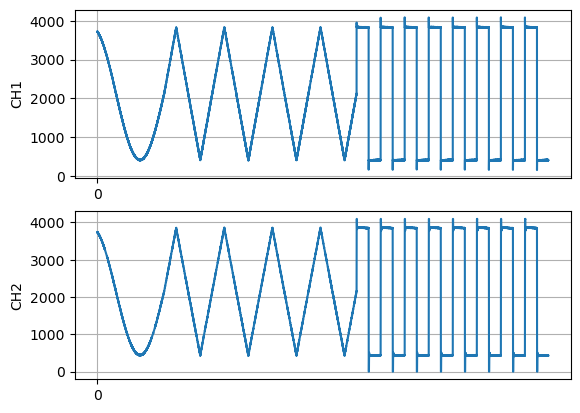

In [58]:
# Enable inline plotting
%matplotlib inline

# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(211)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_xticks(np.arange(0, totlen, framelen))
ax2.grid(True)
ax2.plot(x, wav2)
ax2.set_ylabel('CH2')

plt.show()

del wav1, wav2

## End

In [13]:
# close connection
inst.close_instrument()
print('closed session')

closed session
